In [1]:
import tensorflow as tf
import numpy as np

import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from IPython import display

from iaf_dynamics import DVBFNoKL
from world import PendulumFullObs

def sample_batch(X, U, batch_size):
    sample = np.random.rand(batch_size) * X.shape[1]
    sample = sample.astype(int)

    batch_x = X[:, sample]
    batch_u = U[:, sample]
    
    return batch_x, batch_u

In [2]:
# Get the dataset
world = PendulumFullObs()
X, U, R, S = world.get_data_set(episodes=500, steps=50)

[2017-09-29 18:47:42,106] Making new env: Pendulum-v0


In [3]:
# Define the model
n_obs = 3
n_control = 1
n_latent =  4
n_enc = 10
learning_rate = 0.001
min_learning_rate = 0.0001
decay_rate = 0.997
m = DVBFNoKL(n_obs, n_control, n_latent, n_enc, learning_rate)

('z0 shape: ', TensorShape([Dimension(None), Dimension(4)]))
('log_q0 shape', TensorShape(None))
('log_q0 shape', TensorShape(None))
('log_p0 shape', TensorShape(None))
('p_mean', TensorShape([Dimension(None), Dimension(4)]))
('p_var', <tf.Tensor 'scan/while/add_1:0' shape=(?, 4) dtype=float32>)
('log_q_prev', TensorShape(None))
('q_var', TensorShape([Dimension(None), Dimension(4)]))
('log_q', TensorShape(None))


('log_p', TensorShape(None))


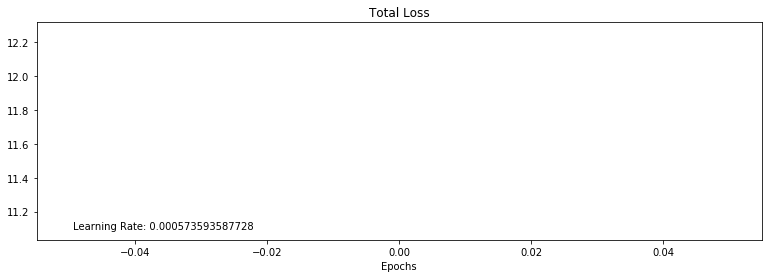

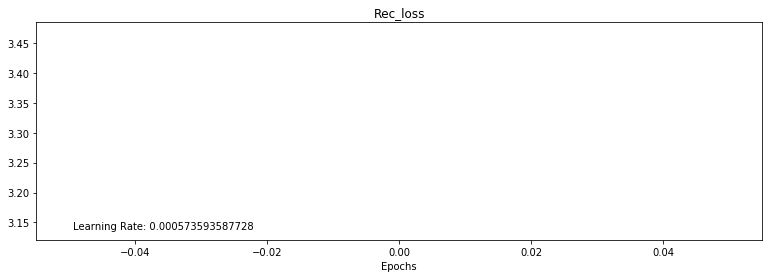

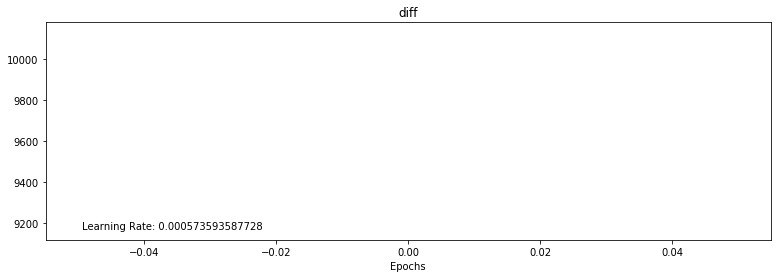

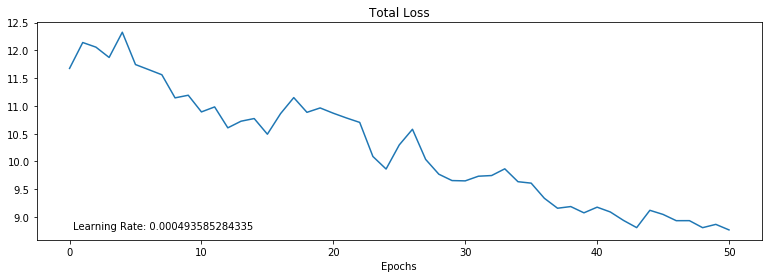

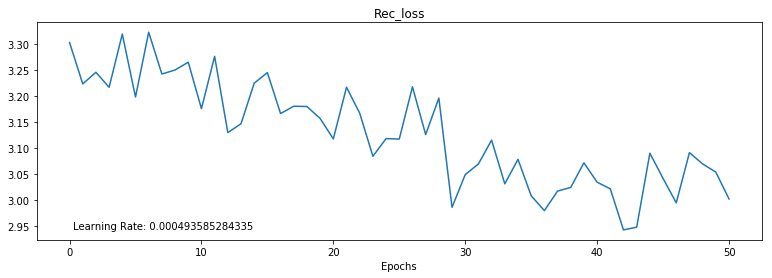

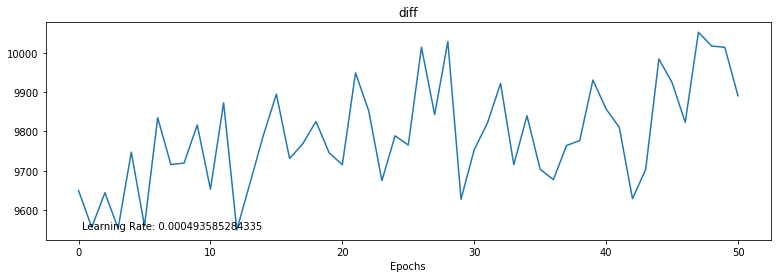

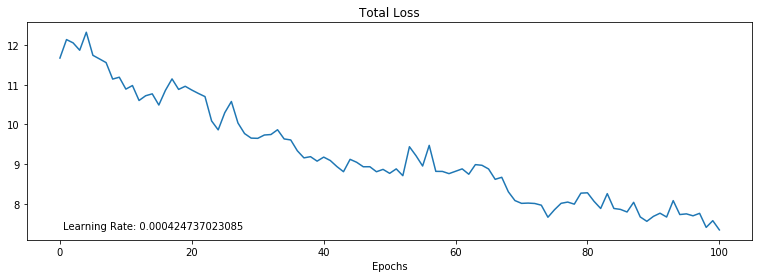

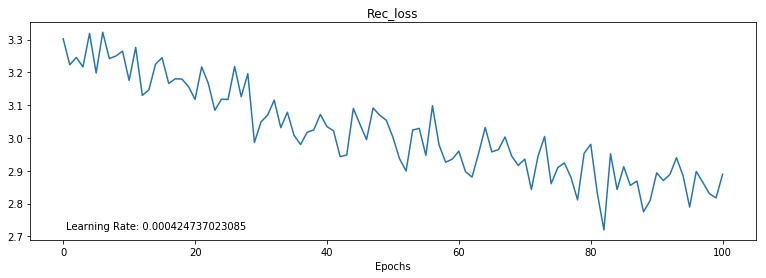

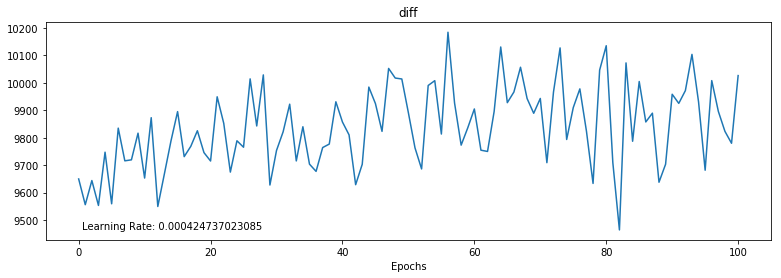

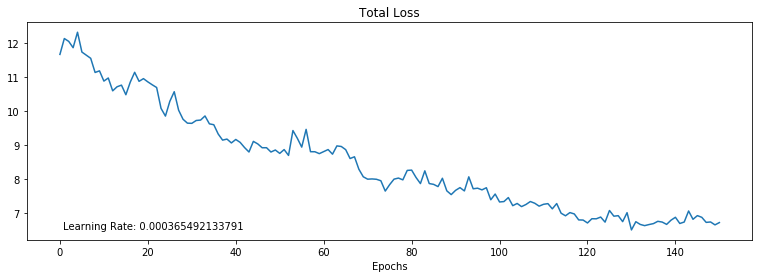

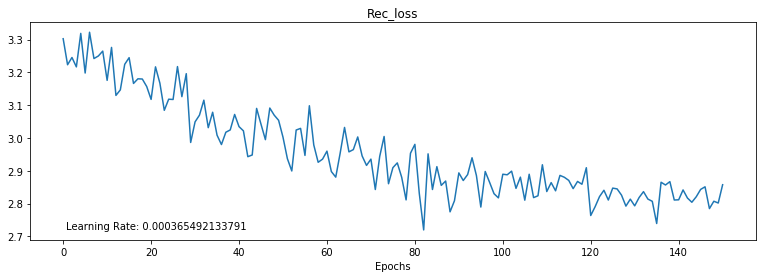

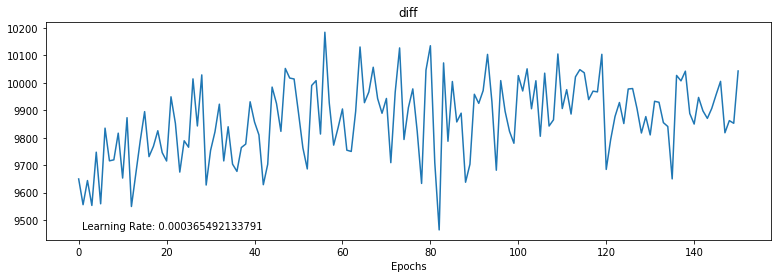

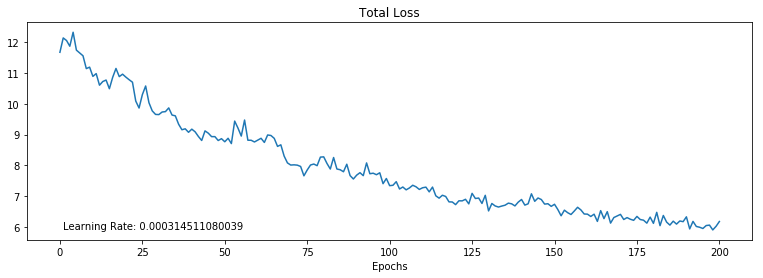

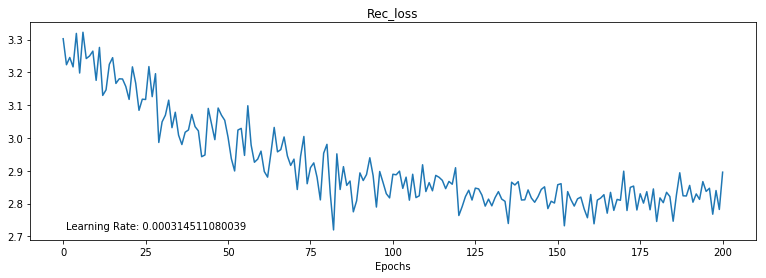

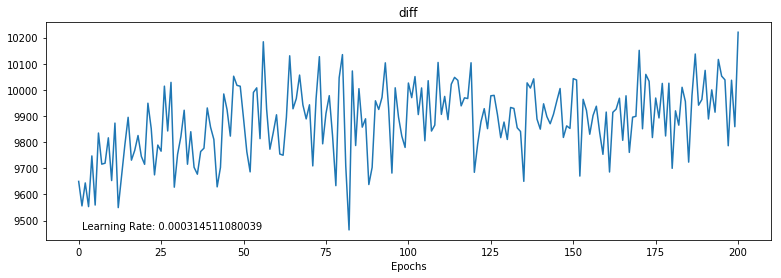

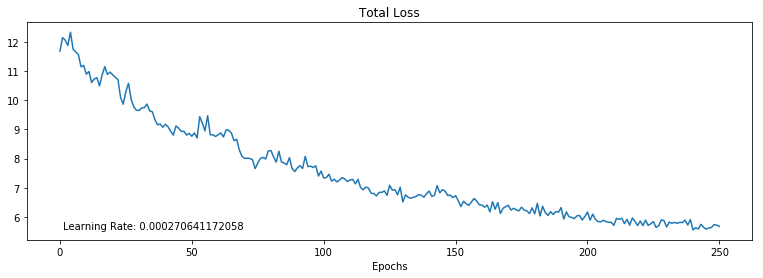

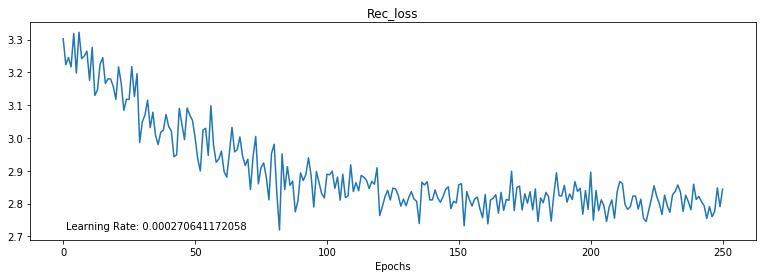

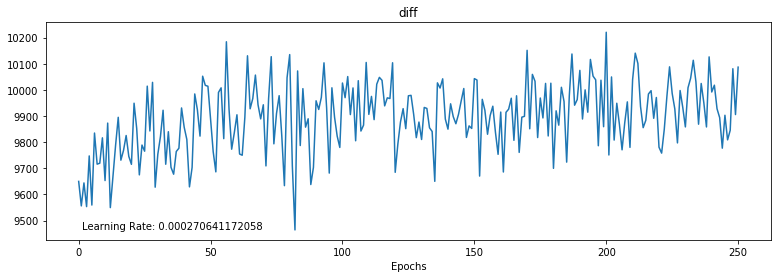

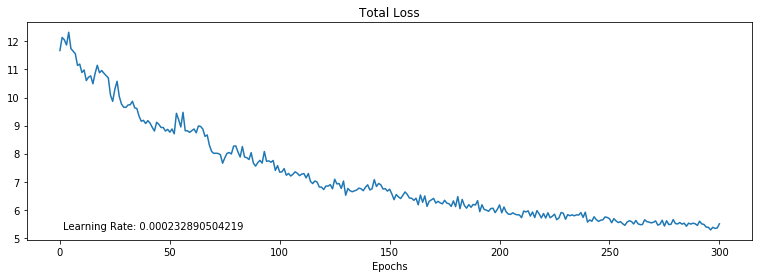

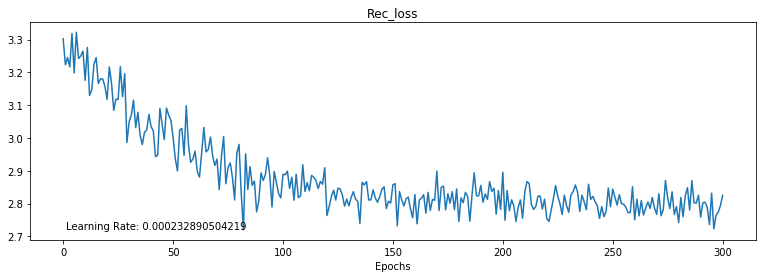

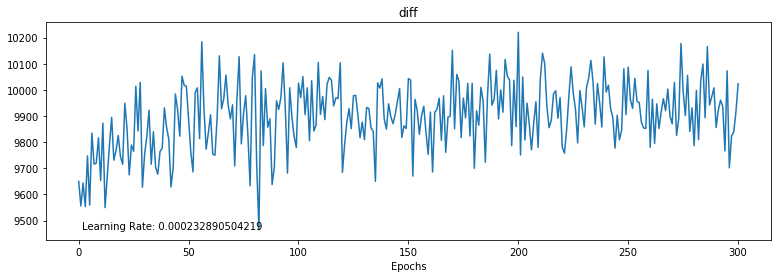

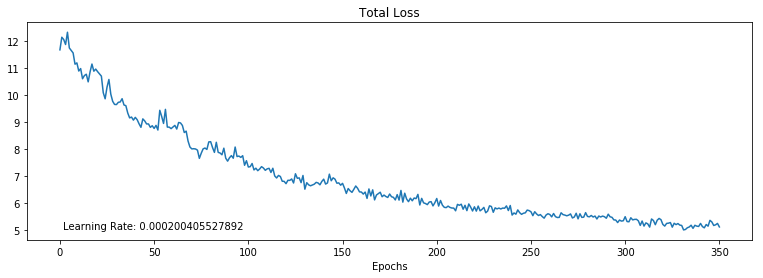

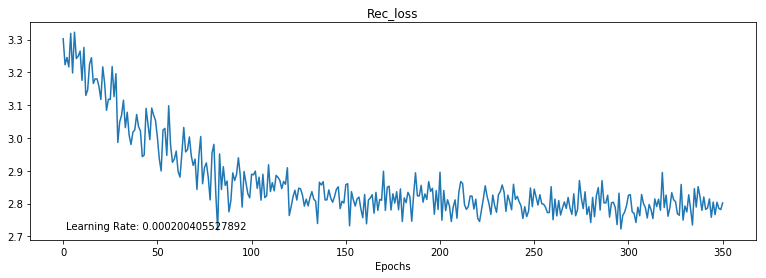

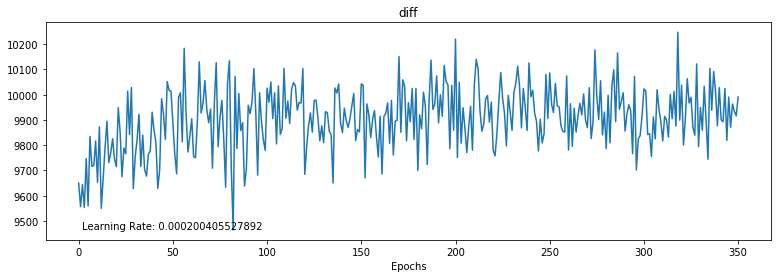

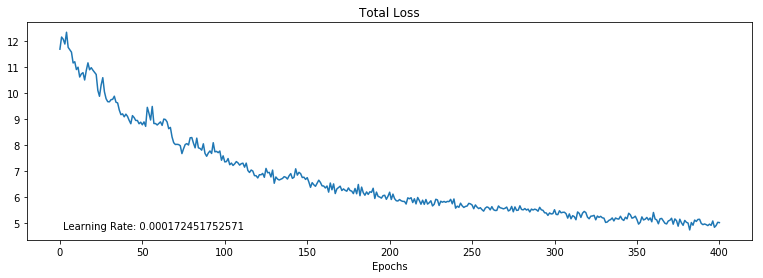

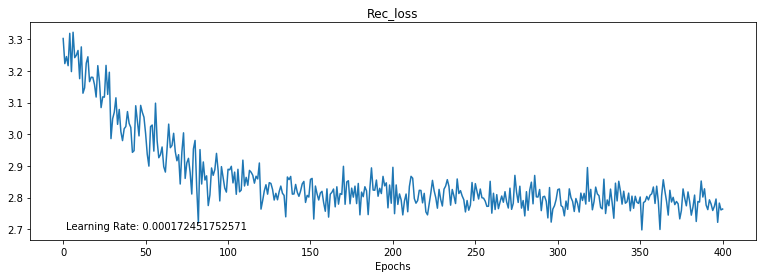

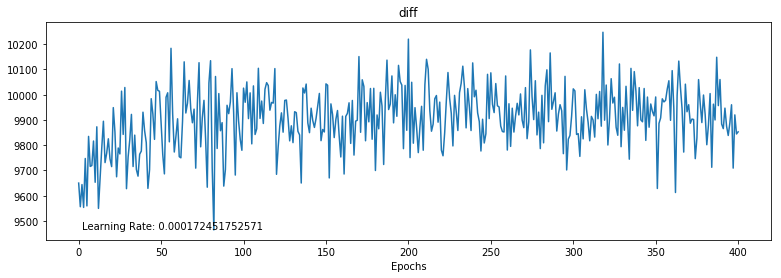

KeyboardInterrupt: 

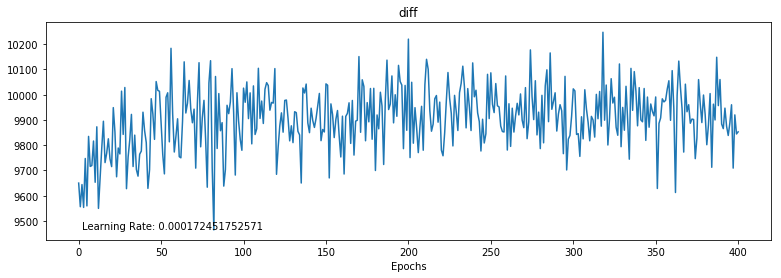

In [9]:
# Training parameters
training_epochs = 1000
batch_size = 128
steps_per_epoch = X.shape[1] / batch_size
display_step = 50

epochs = []
total_loss = []
tots_rec_loss = []
gen_x_diff = []

# Training cycle
for epoch in range(training_epochs):
    
    # Decay the learning rate
    if learning_rate > min_learning_rate:
        learning_rate *= decay_rate

    # Train one epoch 
    avg_total_loss = .0
    avg_rec_loss = .0
    avg_diff = .0
    for i in range(steps_per_epoch):
        batch_x, batch_u = sample_batch(X, U, batch_size)
        temp_total_loss, rec_loss, gen_x_mean = m.train(batch_x, batch_u, learning_rate)
        #print(rec_loss)
        #print("kl -  analytical: ", kl, " , monte carlo: ", mc_est)
        avg_total_loss += temp_total_loss
        avg_rec_loss += rec_loss
        avg_diff += np.sum(np.abs(gen_x_mean - batch_x[1:]))
    avg_total_loss /= steps_per_epoch
    avg_rec_loss /= steps_per_epoch
    avg_diff /= steps_per_epoch
    
    total_loss.append(avg_total_loss)
    tots_rec_loss.append(avg_rec_loss)
    gen_x_diff.append(avg_diff)
    epochs.append(epoch)
    #print ('avg_total_loss ', avg_total_loss, 'gen_x_diff ', gen_x_diff )
    # Plot the results
    if epoch % display_step == 0:

        plt.close()
        f, axarr = plt.subplots(1, 1, figsize=(13, 4))
        axarr.plot(epochs, total_loss)
        axarr.set_xlabel('Epochs')
        axarr.set_title('Total Loss')
        axarr.annotate("Learning Rate: " + str(learning_rate), xy=(0.05, 0.05), xycoords='axes fraction')

        #axarr.set_ylim(-14.0, 10)

        display.display(plt.gcf())
        display.clear_output(wait=True)
    if epoch % display_step == 0:

        plt.close()
        f, axarr = plt.subplots(1, 1, figsize=(13, 4))
        axarr.plot(epochs, tots_rec_loss)
        axarr.set_xlabel('Epochs')
        axarr.set_title('Rec_loss')
        axarr.annotate("Learning Rate: " + str(learning_rate), xy=(0.05, 0.05), xycoords='axes fraction')

        #axarr.set_ylim(-14.0, 10)

        display.display(plt.gcf())
        display.clear_output(wait=True)
    if epoch % display_step == 0:

        plt.close()
        f, axarr = plt.subplots(1, 1, figsize=(13, 4))
        axarr.plot(epochs, gen_x_diff)
        axarr.set_xlabel('Epochs')
        axarr.set_title('diff')
        axarr.annotate("Learning Rate: " + str(learning_rate), xy=(0.05, 0.05), xycoords='axes fraction')

        #axarr.set_ylim(-14.0, 10)

        display.display(plt.gcf())
        display.clear_output(wait=True)

    # Plot the results
    # if epoch % display_step == 0:
    # 
    #     plt.close()
    #     f, axarr = plt.subplots(1, 3, figsize=(13, 4))
    #     axarr[0].plot(epochs, total_loss)
    #     axarr[0].set_xlabel('Epochs')
    #     axarr[0].set_title('Total Loss')
    #     axarr[0].annotate("Learning Rate: " + str(learning_rate), xy=(0.05, 0.05), xycoords='axes fraction')
    #     axarr[0].set_ylim(-9.0, 10)
    #     axarr[1].plot(epochs, tots_rec_loss)
    #     axarr[1].set_xlabel('Epochs')
    #     axarr[1].set_title('Rec Loss')
    #     axarr[1].set_ylim(-9.0, 10)
    #     axarr[2].plot(epochs, gen_x_diff)
    #     axarr[2].set_xlabel('Epochs')
    #     axarr[2].set_title('KL Loss')
    #     axarr[2].set_ylim(.0, 10)
    # 
    #     print ('total loss at epoch: ', epoch, ' : ',total_loss[-1])
    # 
    #     display.display(plt.gcf())
    #     display.clear_output(wait=True)

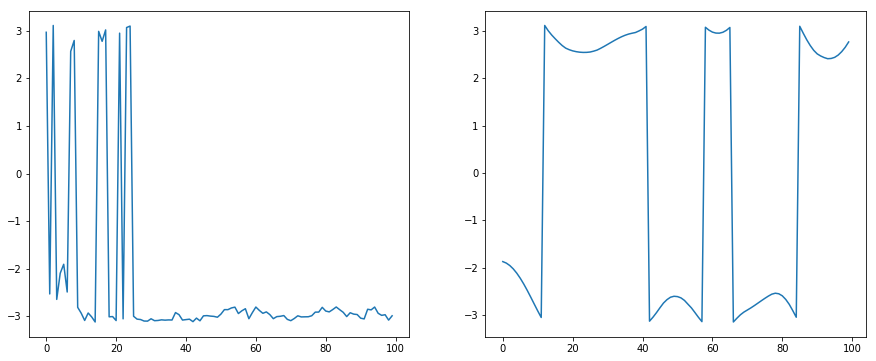

In [10]:
# Get the true trajectory
# print('last loss: ', total_loss[-1])
# print('last loss: ', total_loss[-1])
# print('last loss: ', total_loss[-1])
X_temp, U_temp, R_temp, S_temp = world.get_data_set(episodes=100,steps=100)
x_obs = m.sess.run((m.gen_x_mean), feed_dict={m.x: X_temp, m.u:U_temp})

# Plot the position and reward of low dim pendulum
e = int(np.random.rand() * 100)
f, axarr = plt.subplots(1, 2, figsize=(15, 6))
axarr[0].plot(np.arctan2(x_obs[:, e, 1], x_obs[:, e, 0]))
axarr[1].plot(np.arctan2(X_temp[:, e, 1], X_temp[:, e, 0]))
plt.show()